# Sentiment Analysis: Customer Feedback

# Notebook 3.1: Recurrent Neural Network Model + *Tokenizer*

In this notebook, customer feedback/comments/reviews are analyzed to determine whether they are positive, negative, or neutral using the Recurrent Neural Network (RNN) model.

## Setup

In [1]:
import os

# libraries to work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# libraries for machine learning
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# libraries for saving/loading models
import pickle

C:\Users\ASUS\anaconda3\envs\hexsoftwares_ml_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Loading Clean Datasets

In [2]:
df_train = pd.read_pickle('../datasets/final_training_dataset.pkl')
df_train

,review_text,sentiment
0,wow love place,1
1,crust not good,0
2,not tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
...,...,...
25895,disappoint qualiti,0
25896,amaz experi highli recommend,1
25897,fast deliveri great packag,1
25898,great valu money,1


In [3]:
df_test = pd.read_pickle('../datasets/final_testing_dataset.pkl')
df_test

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


## Recurrent Neural Network: Data Splitting

The training dataset is split into features (X) and target (y). Each of these is further divided into a training set (X_train, y_train) and a validation set (X_val, y_val) to evaluate the model's generalization ability. A separate test set (X_test, y_test) is kept aside and does not need further division.

The **labels (y)** in the training, validation, and test datasets **must be integers** because 
the loss function `sparse_categorical_crossentropy` requires numeric (integer) labels for multi-class classification.

In [4]:
# features and labels for the training dataset
X = df_train['review_text']  # raw text, not vectorized
y = df_train['sentiment'].values.astype(int)  # convert to integers

# split the training dataset into validation dataset
raw_X_train, raw_X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# features and labels for the testing dataset
raw_X_test = df_test['review_text']  # raw text, not vectorized
y_test = df_test['sentiment'].values.astype(int)  # convert to integers

# check the shape and data type of the datasets before and after splitting
elements = {
    "X": X,
    "raw_X_train": raw_X_train,
    "raw_X_val": raw_X_val,
    "raw_X_test": raw_X_test,
    "y": y,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

for name, element in elements.items():
    print(f"{name} shape: {element.shape}")
    print(f"{name} data type: {element.dtype}\n")

X shape: (25900,)
X data type: object

raw_X_train shape: (18130,)
raw_X_train data type: object

raw_X_val shape: (7770,)
raw_X_val data type: object

raw_X_test shape: (4321,)
raw_X_test data type: object

y shape: (25900,)
y data type: int64

y_train shape: (18130,)
y_train data type: int64

y_val shape: (7770,)
y_val data type: int64

y_test shape: (4321,)
y_test data type: int64



After splitting the dataset, the class distributions for the training and validation datasets should be similar since they come from the same dataset. The test dataset, however, can have a different distribution as it comes from a completely separate dataset, which is acceptable in real-world scenarios.

In [5]:
# get distributions
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

# calculate totals
train_total = len(y_train)
val_total = len(y_val)
test_total = len(y_test)

# print to compare distributions with percentages
print("training dataset label distribution:")
for label, count in sorted(train_dist.items()):
    percentage = (count / train_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {train_total:,}")

print("\nvalidation dataset label distribution:")
for label, count in sorted(val_dist.items()):
    percentage = (count / val_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {val_total:,}")

print("\ntesting dataset label distribution:")
for label, count in sorted(test_dist.items()):
    percentage = (count / test_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {test_total:,}")

training dataset label distribution:
  (Class 0): 7189 (39.65%)
  (Class 1): 7356 (40.57%)
  (Class 2): 3585 (19.77%)
  Total: 18,130

validation dataset label distribution:
  (Class 0): 3152 (40.57%)
  (Class 1): 3118 (40.13%)
  (Class 2): 1500 (19.31%)
  Total: 7,770

testing dataset label distribution:
  (Class 0): 1332 (30.83%)
  (Class 1): 2989 (69.17%)
  Total: 4,321


## Recurrent Neural Network: Encoding

The `Tokenizer` is a text preprocessing method from the `tensorflow.keras.preprocessing.text` library. It is used to **transform a collection of review texts into sequences of integers**, where each integer represents a unique word in the vocabulary. The process is as follows:
- `fit_on_texts()`: Learns the vocabulary from the training data and assigns an integer to each unique word (does not create sequences yet).
- `texts_to_sequences()`: Converts text into sequences of integers based on the learned vocabulary.
- `pad_sequences()`: Pads or truncates sequences to ensure all sequences have the same length.

***

Each row of the matrix corresponds to a review, and each column corresponds to a position in the sequence (not a unique word). The **value at each position represents the word ID** at that position in the review.

Example: Given a review "this is is not good":
- "this is is not good" &#8594; {this: 1, is: 2, not: 3, good: 4} &#8594; [1 2 2 3 4]
- row: "this is is not good"
- column: [1 2 2 3 4] 

***

It **requires padding** because it creates <u>variable-length</u> sequences (not fixed-size vectors) for each review. The length of each sequence is determined by the number of words in that review. To make all sequences the same length for the RNN model, `keras.preprocessing.sequence.pad_sequences()` is used with the `maxlen` parameter to either:
- **Pad** shorter sequences (with zeros typically at the beginning or end)
- **Truncate** longer sequences.

Example: If `maxlen = 5`:
- "this is not good" &#8594; [1 2 3 4] &#8594; [0 1 2 3 4] (padded)
- "this is a very good review" &#8594; [1 2 5 6 4 7] &#8594; [1 2 5 6 4] (truncated)

***
It **preserves the order of words** and represents each word occurrence in sequence, implicitly maintaining count information through repetition (rather than aggregating occurrences into explicit count values). Different word sequences will produce different encoded sequences, allowing the RNN to learn from word order and context.

Example:
- "this is not good" &#8594; [1 2 3 4]
- "this good is not" &#8594; [1 4 2 3]

***

### Out-of-Vocabulary (OOV) Token

The `oov_token` parameter in the `Tokenizer` is an optional mechanism for handling words not encountered during training. When an OOV token is specified (e.g., oov_token="<OOV>"), any unseen word in validation or test data is mapped to a special token index rather than being discarded. Without an OOV token, unknown words are ignored and removed from sequences, which is appropriate only when training and test vocabularies are highly similar.

- **Use an OOV token** when test data may contain **unseen words** or robustness to new vocabulary is required
    - vocab_size = unique features/words + OOV (ID=1)
    - token_size = vocab_size + padding (ID=0) = vocab_size + 1 &#8594; `Embedding(token_size, ...)`
    
- **Skip the OOV token** when training and test vocabularies are tightly controlled and **similar**
    - vocab_size = unique features/words
    - token_size = vocab_size + padding (ID=0) = vocab_size + 1 &#8594; `Embedding(token_size, ...)`

For sentiment analysis tasks, an OOV token is used to handle natural variations in review language and vocabulary.

In [6]:
# initialize tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(raw_X_train)

# save the Tokenizer which contains the vocabulary
os.makedirs('../text_transformers', exist_ok=True)
with open('../text_transformers/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(raw_X_train)
X_val_sequences = tokenizer.texts_to_sequences(raw_X_val)
X_test_sequences = tokenizer.texts_to_sequences(raw_X_test)

MAX_LEN = 80  # due to NOTEBOOK 1

# pad sequences to same length
X_train = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post')
X_val = pad_sequences(X_val_sequences, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post')

In [7]:
# print the matrix dimensions
print(f"train matrix dimensions: {X_train.shape}")
print(f"val matrix dimensions: {X_val.shape}")

train matrix dimensions: (18130, 80)
val matrix dimensions: (7770, 80)


In [8]:
# check actual vocabulary size
vocab_size = len(tokenizer.word_index)
print("USING TOKENIZER:")
print(f"  total number of unique features/words in the training data: {vocab_size - 1}")
print(f"  total number of unique features/words and the oov token in the training data: {vocab_size}")

# compute token size for the Embedding layer
token_size = vocab_size + 1  # adds 1 for padding
print(f"  total number of unique features/words, the padding token, and the oov token in the training data: {token_size}")

USING TOKENIZER:
  total number of unique features/words in the training data: 1228
  total number of unique features/words and the oov token in the training data: 1229
  total number of unique features/words, the padding token, and the oov token in the training data: 1230


## Recurrent Neural Network: Alternative Encoding with *TextVectorization*

Instead of using the `Tokenizer` to convert words to integers and then padding or truncating sequences, the `TextVectorization` layer can perform all of this in one step.

It takes the following parameters:
- `max_tokens`: The maximum number of unique words the model is allowed to know (i.e., the vocabulary size)
- `output_sequence_length`: Analogous to `max_len`; determines the fixed length of output sequences after padding or truncating
- `standardize`: Defines how the text is normalized or cleaned (e.g., lowercasing, stripping punctuation)

The `TextVectorization` layer is then adapted (trained) on the dataset using the `adapt()` method, which builds the vocabulary from the training data. Once adapted, the layer can be used to vectorize input text for model training or inference.

In [9]:
isinstance(raw_X_train, pd.Series)

True

In [10]:
isinstance(raw_X_train, tf.Tensor)

False

In [11]:
# define the tokenized layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=5000,
    output_sequence_length=MAX_LEN,
    standardize=None  # data is already pre-processed
)

# adapt (equivalent to fit_on_texts())
vectorize_layer.adapt(raw_X_train)  ## pd.Series object is fed
vectorize_layer

<TextVectorization name=text_vectorization, built=False>

In [12]:
# recompute vocabulary size and token size for this particular encoding method
alt_vocab_size = vectorize_layer.vocabulary_size()
alt_token_size = alt_vocab_size + 1  # adds 1 for padding
print("USING TEXT VECTORIZATION:")
print(f"  total number of unique features/words in the training data: {alt_vocab_size - 1}")
print(f"  total number of unique features/words and the oov token in the training data: {alt_vocab_size}")
print(f"  total number of unique features/words, the padding token, and the oov token in the training data: {alt_token_size}")

USING TEXT VECTORIZATION:
  total number of unique features/words in the training data: 1230
  total number of unique features/words and the oov token in the training data: 1231
  total number of unique features/words, the padding token, and the oov token in the training data: 1232


## Recurrent Neural Network: Model Architecture

The embedding size or dimension is the output dimension of the `Embedding` layer. Higher value can capture more details but use more memory.

Example: If `Embedding(x, 64)`, each token (a whole or part of a word) becomes a 64-dimensional vector (64 features/dimensions).

***

The long short-term memory or `LSTM` layer is a layer of hidden neurons. It processes the embedding vectors and outputs a vector whose size equals the number of LSTM units. It captures long-range dependencies and contextual meaning in a sentence. Unlike convolutional layers, it processes the sequence step by step to understand how earlier words influence later ones. The number of LSTM units does not need to match the embedding dimension.

Example:
- "I thought the movie would be bad, but it was amazing" &#8594; LSTM captures the contrast between "bad" and "amazing".
- `Embedding(x, 64)` can be used with `LSTM(32)`.

***

The `Dense` layer is also a layer of neurons that outputs probabilities for each class in multi-class classification problems. Thus, the number of Dense units equals the number of classes.

Example: 5 classes corresponds to `Dense(5, activation_function)`.

***

If the problem is binary classification (positive or negative reviews), the activation function `sigmoid` or `softmax` is usable.

If the problem is multi-class classification like this one (positive, negative, or neutral reviews), then the activation function cannot be `sigmoid`. Only `softmax` can be used because it converts the raw outputs into a probability distribution over all classes, ensuring that the probabilities sum to 1.

In [13]:
# define parameters
batch_size = 64
epochs = 10

In [14]:
# model architecture
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(token_size, 64),        # map each token to 64-dim vectors
    tf.keras.layers.LSTM(32),                         # map 64-dim vectors to 32 LSTM units
    tf.keras.layers.Dense(3, activation="softmax")    # 32 LSTM units to 3 classes
])

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The `sparse_categorical_crossentropy` loss function is used for multi-class classification problems where the labels are integers rather than one-hot encoded. It measures the difference between the predicted probability distribution and the true class label.

***

The `rmsprop` or "Root Mean Square Propagation" optimizer is an adaptive learning rate algorithm that adjusts the learning rate for each parameter based on a moving average of squared gradients. It is commonly used for RNNs because it makes training less sensitive to learning rate hyperparameter tuning, performs well on non-stationary problems (like sequential data), and often converges faster and more reliably than basic optimizers like SGD.

***

Although the classes are imbalanced, the F1-macro score is not used to optimize hyperparameters as in the NBC model, which used `GridSearchCV`. This is because:

- RNNs are slower to train, so exhaustive grid search is computationally expensive.
- "Accuracy" is commonly used as the primary metric during training in Keras/TensorFlow workflows.
- Hyperparameter tuning can be done in other ways, such as using **KerasTuner** or manual experimentation.

Therefore, the F1-macro score is only computed during model evaluation. However, it remains an important evaluation metric for assessing model performance on imbalanced datasets.

In [15]:
# compile the model
baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

## Recurrent Neural Network: Model Training & Evaluation

In RNNs, training and validation happen together. For each epoch, the `fit()` method trains on the training dataset and then evaluates on the validation dataset. This process is repeated for all epochs. The method also returns a history object with training and validation metrics automatically tracked per epoch, which helps monitor model performance and detect overfitting during training.

In [16]:
# train the model
history = baseline_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4014 - loss: 1.0555 - sparse_categorical_accuracy: 0.4014 - val_accuracy: 0.4057 - val_loss: 1.0505 - val_sparse_categorical_accuracy: 0.4057
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.3993 - loss: 1.0543 - sparse_categorical_accuracy: 0.3993 - val_accuracy: 0.4057 - val_loss: 1.0507 - val_sparse_categorical_accuracy: 0.4057
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.4044 - loss: 1.0540 - sparse_categorical_accuracy: 0.4044 - val_accuracy: 0.4013 - val_loss: 1.0507 - val_sparse_categorical_accuracy: 0.4013
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.4035 - loss: 1.0542 - sparse_categorical_accuracy: 0.4035 - val_accuracy: 0.4013 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.4013
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4009 - loss: 1.0540 - sparse_categorical_accuracy: 0.4009 - val_accuracy: 0.4013 - val_loss:

## Recurrent Neural Network: Loss & Accuracy

In [17]:
# plot function
def plot_loss_and_acc(history, epochs):
    fig, axs = plt.subplots(2 , 1)
    fig.set_size_inches(18.5, 10.5)
    axs1 = axs[0]
    axs2 = axs[1]

    axs1.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
    axs1.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
    axs1.legend(loc='lower right')
    axs1.set(xlabel='Epoch', ylabel='Accuracy')
    axs1.set_title('Training and Validation Accuracy')
    axs1.grid(True)

    axs2.plot(range(epochs), history.history['loss'], label='Training Loss')
    axs2.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
    axs2.legend(loc='upper right')
    axs2.set(xlabel='Epoch', ylabel='Error')
    axs2.set_title('Training and Validation Loss')
    axs2.grid(True)
    fig.tight_layout()
    plt.show()

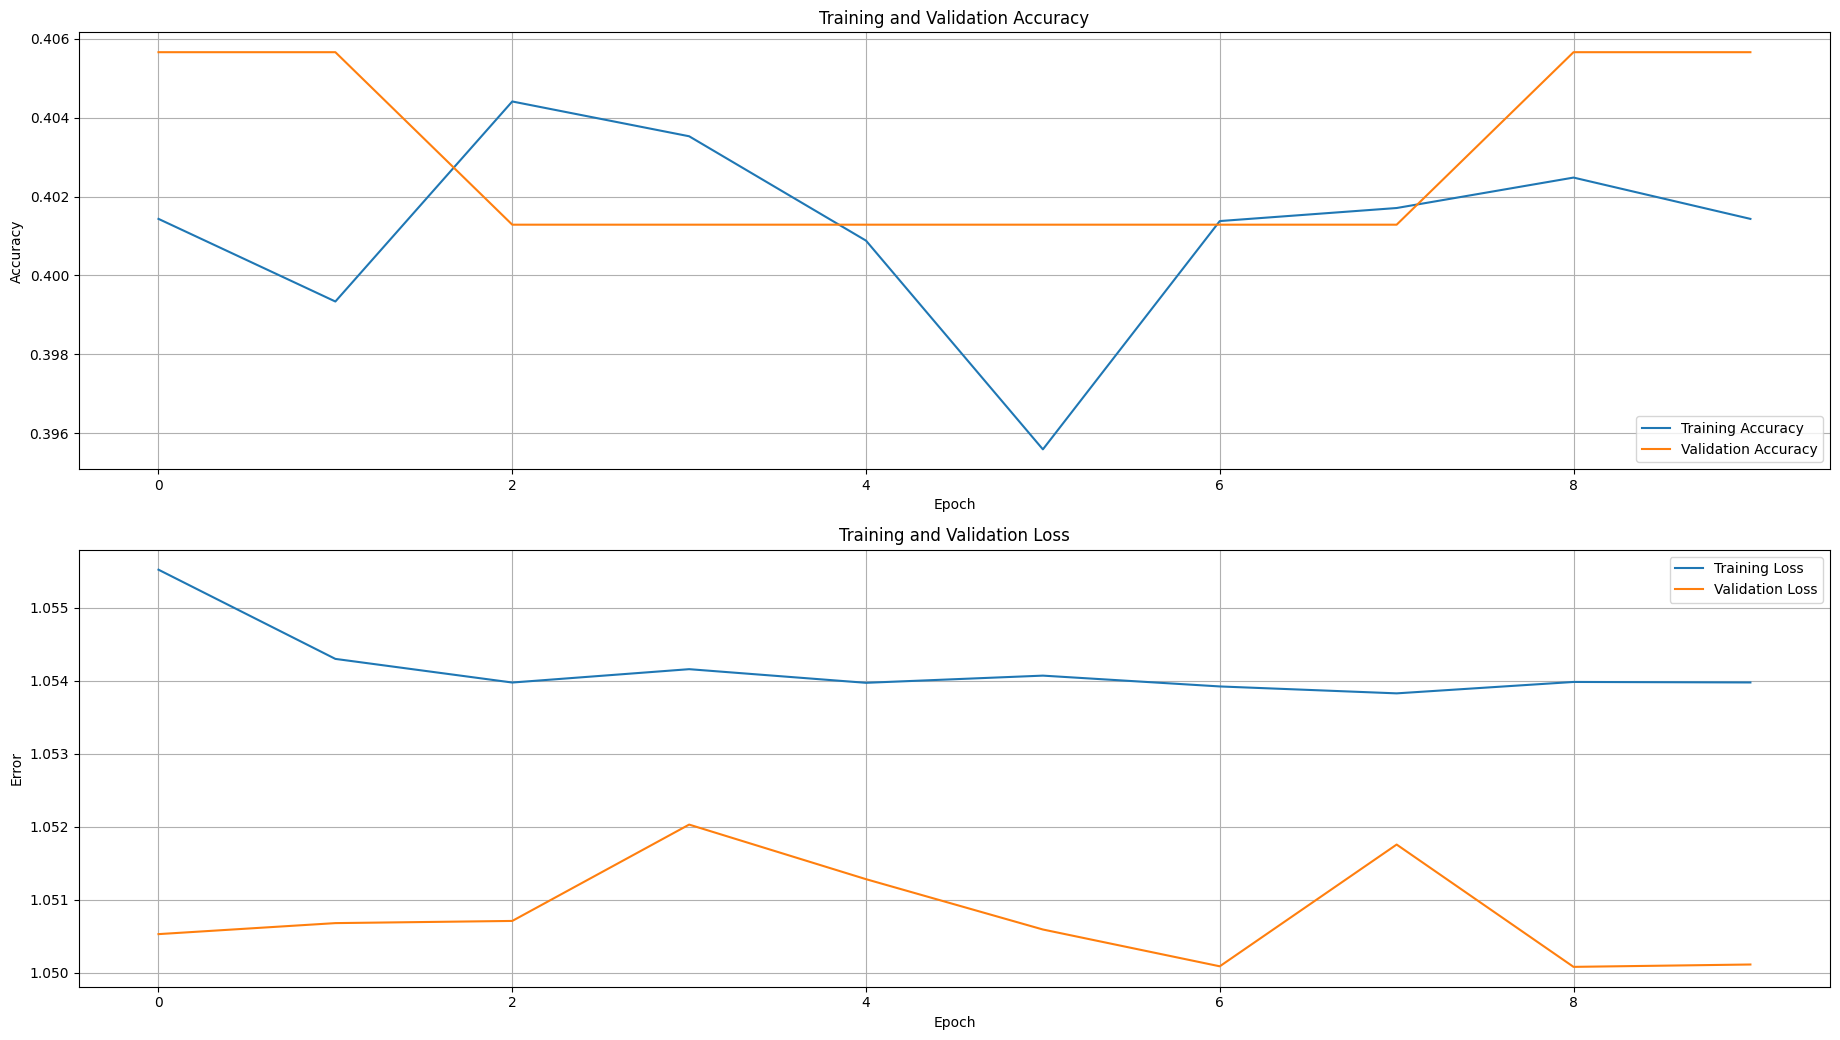

In [18]:
# plot
plot_loss_and_acc(history, epochs)

## DataFrame For Model Comparison

Before improving the model and creating variants, the data for each model must be tracked so that the best one can be chosen later.

In [19]:
columns = ['encoding', 'val_loss', 'val_accuracy', 'test_loss', 'test_accuracy', 'embedding_dim', 'conv_filters', 'lstm_units', 'learning_rate']
df_model_results = pd.DataFrame(columns=columns)
df_model_results

,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate


In [20]:
# helper function to add data to the comparison dataframe easily
def add_to_df_models(name, encoding, embedding_dim, lstm_units, learning_rate, test_eval=True, conv_filters=None):
    l = [
        encoding,
        round(history.history['val_loss'][-1], 4),
        round(history.history['val_accuracy'][-1], 4),
        round(results[0], 4) if test_eval==True else None,
        round(results[1], 4) if test_eval==True else None,
        embedding_dim,
        conv_filters,
        lstm_units,
        learning_rate
    ]
    
    df_model_results.loc[name] = l

# add the baseline model to the comparison dataframe
add_to_df_models('baseline_model', 'Tokenizer', test_eval=False, embedding_dim=64, lstm_units=32, learning_rate='rmsprop (default)')
df_model_results

,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,None,None,64,None,32,rmsprop (default)


## Recurrent Neural Network: Improving Model Architecture, Re-Training, & Re-Evaluation

According to the graph, both accuracy and loss appear to fluctuate rather than show gradual improvement. This indicates that the current baseline model performs poorly even before evaluation on the test dataset. Therefore, the model is rebuilt with three newly added layers to improve feature extraction and sequence understanding.

***

The `Conv1D` layer is a one-dimensional convolutional layer that detects local patterns (such as short phrases) in a sequence (sentence). It slides filters over the embedded text to identify important keyword combinations very efficiently. While it is often fast and surprisingly accurate at capturing local sentiment cues, it can miss subtle context that spans a longer portion of a sentence, such as sarcasm.

Example: "the menu is very good" &#8594; "very good"

***

The `MaxPooling1D` layer is a down-sampling layer used to shrink the output from the previous layer. It keeps only the most important features by selecting the maximum value from small regions of the sequence. This reduces sequence length, removes noise, and makes the data more manageable for the next layer.

***

After the `LSTM` has captured contextual information across the sentence, its output is further summarized using the `GlobalAveragePooling1D` layer. This layer collapses the entire sequence into a single fixed-length vector by averaging each feature across all time steps. This helps retain the most important overall sentiment features while reducing model complexity.

***

By using an `Embedding` layer with `Conv1D`, the model learns meaningful word representations and detects important local sentiment patterns. By adding `MaxPooling1D`, these patterns are compressed to retain only the strongest signals while reducing noise. By adding an `LSTM`, the model evolves to understand sentence-level context and long-term dependencies between words.
By adding `GlobalAveragePooling1D`, the model finally becomes a compact and efficient sentiment classifier that summarizes the entire sentence before making a prediction using the `Dense` layer.

Example:
> "The food was surprisingly good but a bit salty" &#8594;

> &#8594; (Embedding): converts each word into a dense vector representing its meaning &#8594;

> &#8594; (Conv1D): detects key local patterns like "surprisingly good" and "salty" &#8594;

> &#8594; (MaxPooling1D): keeps the strongest signals from these patterns, i.e., compresses to ["surprisingly good", "salty"] while ignoring weaker words &#8594;

> &#8594; (LSTM): captures sentence-level context: positive overall but slightly negative at the end &#8594;

> &#8594; (GlobalAveragePooling1D): summarizes the entire sentence into a single vector capturing overall sentiment &#8594;

> &#8594; (Dense): predicts the final sentiment class.

In [21]:
# define parameters
batch_size = 64
epochs = 10

# model architecture
enhanced_baseline_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(token_size, 64),                     # map each token to 64-dim vectors
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),  # detect local patterns/phrases
    tf.keras.layers.MaxPooling1D(pool_size=2),                     # keep strongest features, reduce sequence length
    tf.keras.layers.LSTM(32, return_sequences=True),               # understand sentence-level context
    tf.keras.layers.GlobalAveragePooling1D(),                      # summarize sequence into a single vector
    tf.keras.layers.Dense(3, activation="softmax")                 # output 3-class sentiment prediction
])

enhanced_baseline_model.summary()

# compile the model
enhanced_baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8488 - loss: 0.3243 - sparse_categorical_accuracy: 0.8488 - val_accuracy: 0.9882 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9882
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9911 - loss: 0.0273 - sparse_categorical_accuracy: 0.9911 - val_accuracy: 0.9915 - val_loss: 0.0304 - val_sparse_categorical_accuracy: 0.9915
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9950 - loss: 0.0188 - sparse_categorical_accuracy: 0.9950 - val_accuracy: 0.9933 - val_loss: 0.0302 - val_sparse_categorical_accuracy: 0.9933
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9960 - loss: 0.0148 - sparse_categorical_accuracy: 0.9960 - val_accuracy: 0.9925 - val_loss: 0.0306 - val_sparse_categorical_accuracy: 0.9925
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9979 - loss: 0.0089 - sparse_categorical_accuracy: 0.9979 - val_accuracy: 0.9924 - val_loss: 0.0

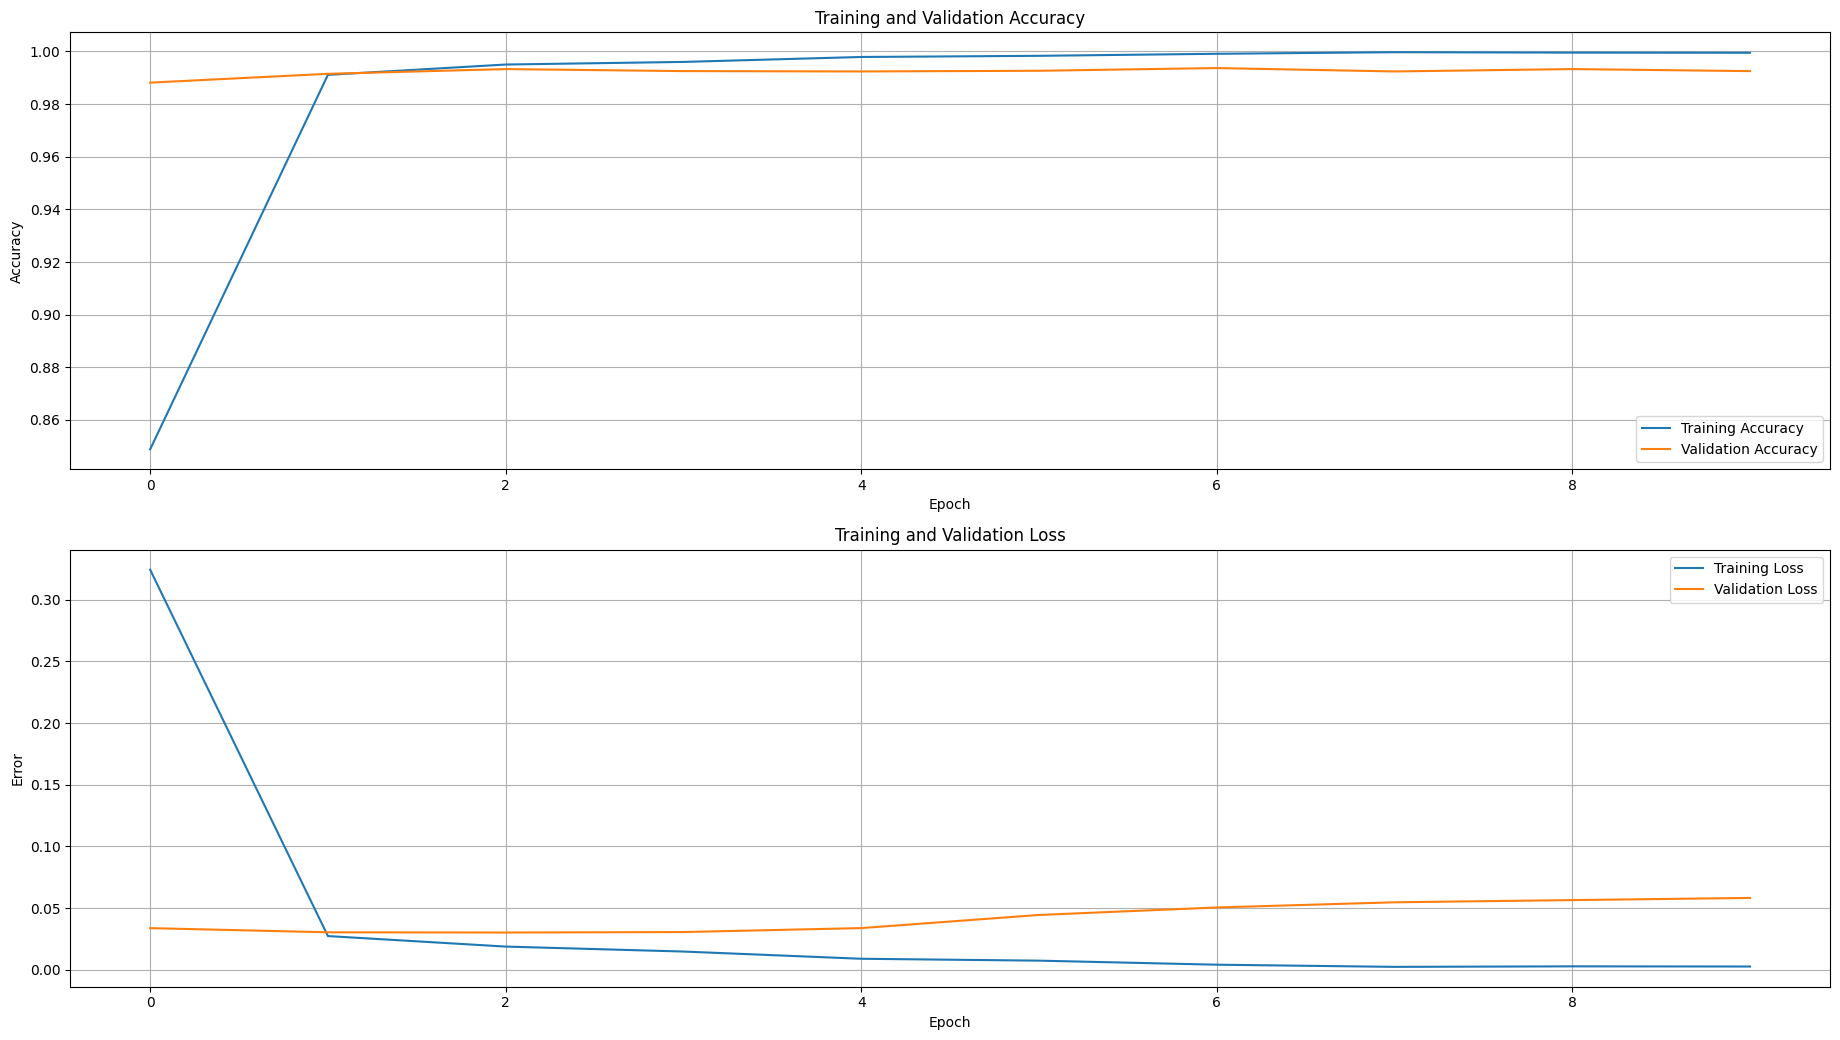

In [22]:
# train the model
history = enhanced_baseline_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

# plot
plot_loss_and_acc(history, epochs)

In [23]:
# evaluate on test data using the enhanced baseline model # uses tokenizer to encode
results = enhanced_baseline_model.evaluate(X_test, y_test)
print(f"loss on test data with the enhanced baseline model: {results[0]:.4f}")
print(f"accuracy on test data with the enhanced baseline model: {results[1]:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7804 - loss: 1.6447 - sparse_categorical_accuracy: 0.7804
loss on test data with the enhanced baseline model: 1.6447
accuracy on test data with the enhanced baseline model: 0.7804


In [24]:
# add the enhanced baseline model to the comparison dataframe
add_to_df_models('enhanced_baseline_model', 'Tokenizer', test_eval=True, embedding_dim=64, conv_filters=64, lstm_units=32, learning_rate='rmsprop (default)')
df_model_results

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4884\365154708.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_results.loc[name] = l


,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)


The baseline model trained on data encoded with a tokenizer seems to be overfitting, achieving ~100% accuracy. To determine whether the choice of encoding contributes to this overfitting, the same model architecture is also applied to data encoded with `TextVectorization`.

## Recurrent Neural Network: Alternative Model Training & Evaluation with *TextVectorization* Encoding

In [25]:
# define parameters
batch_size = 64
epochs = 10

# model architecture
alt_enhanced_baseline_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),                   # takes raw text, not vectorized
    vectorize_layer,
    tf.keras.layers.Embedding(alt_token_size, 64),                 # map each token to 64-dim vectors
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),  # detect local patterns/phrases
    tf.keras.layers.MaxPooling1D(pool_size=2),                     # keep strongest features, reduce sequence length
    tf.keras.layers.LSTM(32, return_sequences=True),               # understand sentence-level context
    tf.keras.layers.GlobalAveragePooling1D(),                      # summarize sequence into a single vector
    tf.keras.layers.Dense(3, activation="softmax")                 # output 3-class sentiment prediction
])

alt_enhanced_baseline_model.summary()

# compile the model
alt_enhanced_baseline_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 80)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 80, 64)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 39, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 39, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,715 (405.14 KB)

 Trainable params: 103,715 (405.14 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# convert all features into tf.string datatype for model training # do it only after the split
alt_raw_X_train = tf.constant(raw_X_train, dtype=tf.string)
alt_raw_X_val = tf.constant(raw_X_val, dtype=tf.string)
alt_raw_X_test = tf.constant(raw_X_test, dtype=tf.string)

# raw_X_train is still a pandas Series # only alt_raw_X_train is a TensorFlow tensor
isinstance(alt_raw_X_train, tf.Tensor)

True

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8561 - loss: 0.2939 - sparse_categorical_accuracy: 0.8561 - val_accuracy: 0.9897 - val_loss: 0.0250 - val_sparse_categorical_accuracy: 0.9897
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9915 - loss: 0.0258 - sparse_categorical_accuracy: 0.9915 - val_accuracy: 0.9924 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9924
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9948 - loss: 0.0160 - sparse_categorical_accuracy: 0.9948 - val_accuracy: 0.9927 - val_loss: 0.0256 - val_sparse_categorical_accuracy: 0.9927
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9966 - loss: 0.0110 - sparse_categorical_accuracy: 0.9966 - val_accuracy: 0.9925 - val_loss: 0.0242 - val_sparse_categorical_accuracy: 0.9925
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9983 - loss: 0.0072 - sparse_categorical_accuracy: 0.9983 - val_accuracy: 0.9928 - val_loss: 

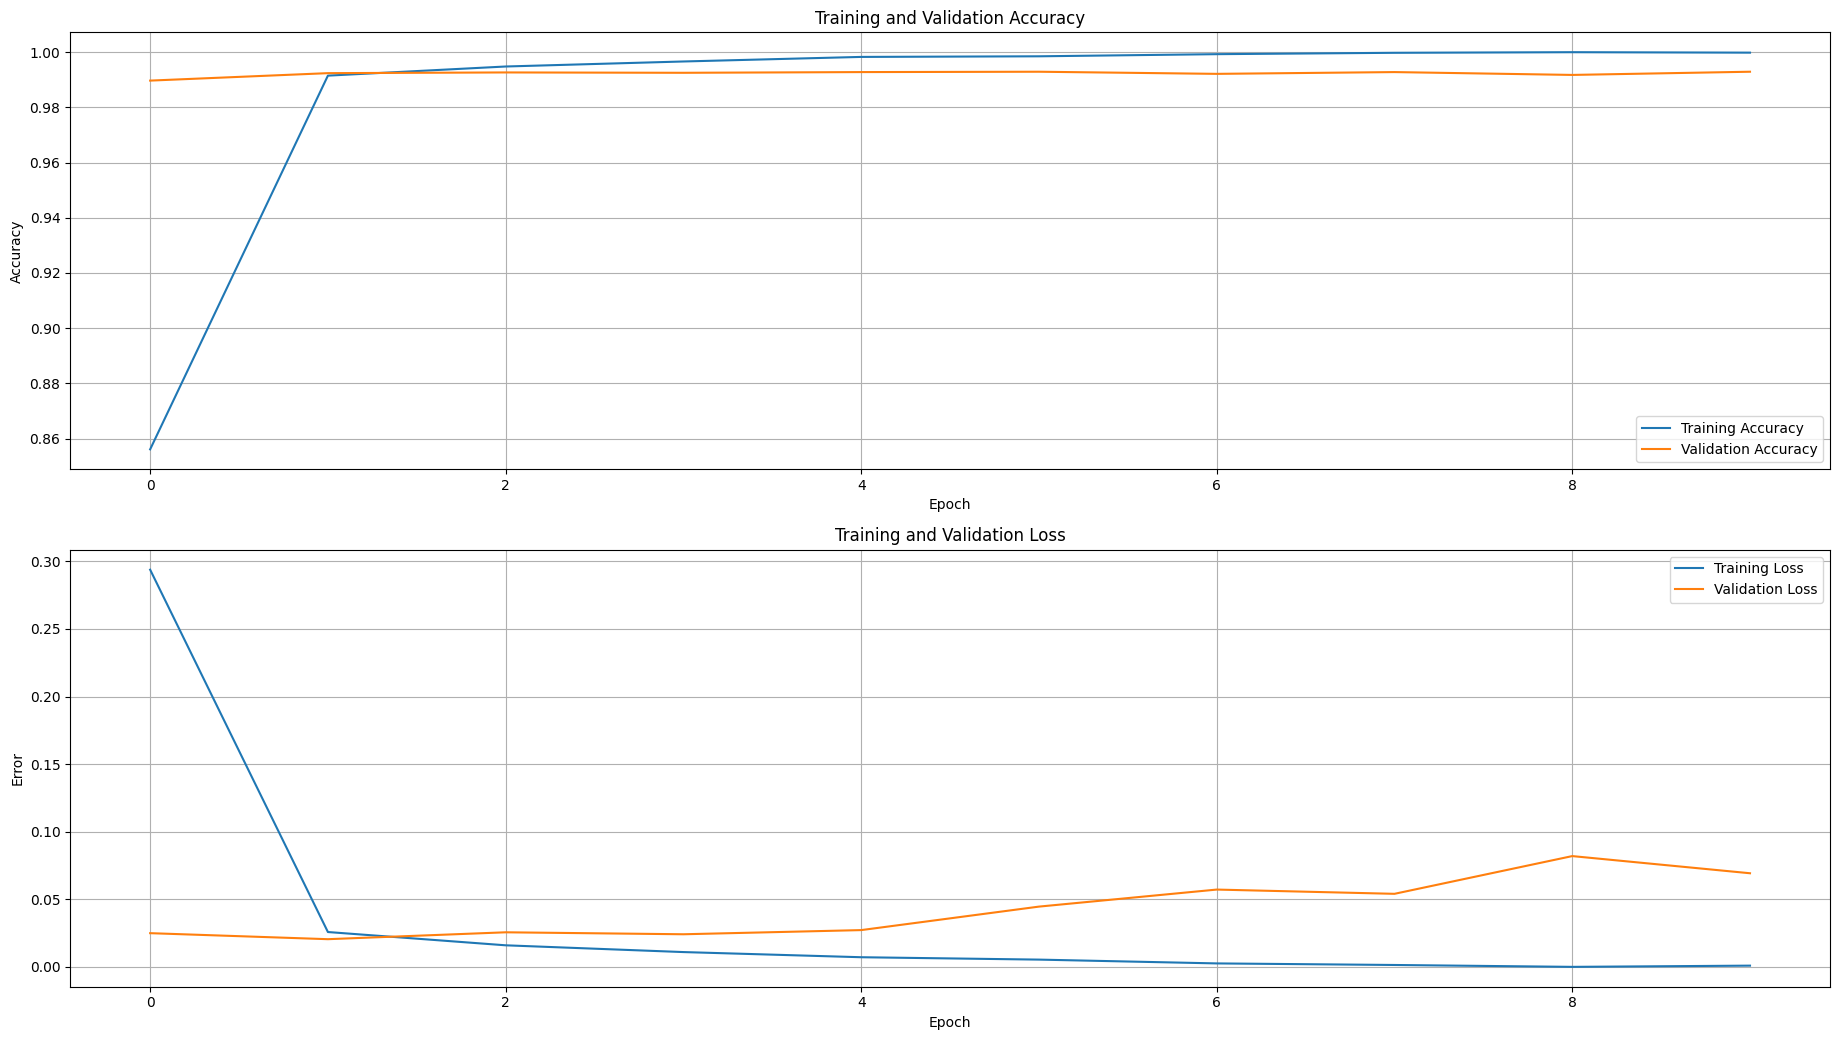

In [27]:
# train the model
history = alt_enhanced_baseline_model.fit(
    alt_raw_X_train, y_train,  # raw text, not vectorized
    epochs=epochs,
    validation_data=(alt_raw_X_val, y_val)  # raw text, not vectorized
)

# plot
plot_loss_and_acc(history, epochs)

In [28]:
# evaluate on test data using the alternatively-encoded enhanced baseline model # uses text vectorization to encode
results = alt_enhanced_baseline_model.evaluate(alt_raw_X_test, y_test)
print(f"loss on test data with the alternative-encoded enhanced baseline model: {results[0]:.4f}")
print(f"accuracy on test data with the alternatively-encoded enhanced baseline model: {results[1]:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6910 - loss: 2.2458 - sparse_categorical_accuracy: 0.6910
loss on test data with the alternative-encoded enhanced baseline model: 2.2458
accuracy on test data with the alternatively-encoded enhanced baseline model: 0.6910


In [29]:
# add the alternatively-encoded enhanced baseline model to the comparison dataframe
add_to_df_models('alt_enhanced_baseline_model', 'TextVectorization', test_eval=True, embedding_dim=64, conv_filters=64, lstm_units=32, learning_rate='rmsprop (default)')
df_model_results

,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)
alt_enhanced_baseline_model,TextVectorization,0.0693,0.9929,2.2458,0.6910,64,64,32,rmsprop (default)


## Recurrent Neural Network: Tokenizer VS. TextVectorization

After training the same baseline model with two different input encoding methods, each trained version is evaluated on the testing dataset, since validation is performed automatically during training.

The results show that the enhanced baseline model **exhibits overfitting regardless of the input encoding method**. Both models achieve high training and validation accuracy, but performance drops notably on the testing dataset, indicating limited generalization to unseen data.

## Recurrent Neural Network: Hyperparameter Tuning

The current baseline model may be improved further by finding optimal hyperparameters through tuning. 

Some hyperparameters to tune are:
- Embedding dimension
- Conv1D filters
- LSTM units
- learning rate

***

**KerasTuner** is used here to automate hyperparameter tuning. It can save tuning results and resume tuning if interrupted.

There are various tuner types, such as:
- `kt.RandomSearch(...)`: Randomly tries combinations
- `kt.Hyperband(...)`: Faster, uses early stopping
- `kt.BayesianOptimization(...)`: Uses Bayesian optimization.

A tuner can take such parameters:
- `build_model`: Function that defines the model architecture
- `objective`: Metric to optimize

- `max_trials`: Maximum number of hyperparameter combinations to try
- `executions_per_trial`: Number of times to train the model with the same hyperparameter combination to get a more reliable estimate of performance

- `factor`: Reduction factor that determines how many models are eliminated at each bracket level in Hyperband
    - > At each level, only the top 1/factor of models are kept for further training; the rest are eliminated.
- `hyperband_iterations`: Number of times to run the entire Hyperband algorithm to better control the degree of exploration of the hyperparameter space

- `num_initial_points`: Number of random trials to run before starting Bayesian optimization to help build a baseline model of the hyperparameter space
- `alpha`, `beta`: Parameters to control exploration vs. exploitation
  - Lower $\alpha$ or $\beta$ = more exploitation (using hyperparameters in known good hyperparameter regions, trusting model predictions)
  - Higher $\alpha$ or $\beta$ = more exploration (using hyperparameters in uncertain hyperparameter regions, seeking potentially better results)

- `directory`: Folder where tuning results are saved
- `project_name`: Subfolder for organizing results within the directory

In [30]:
# define model-building function for reduced dimensions to combat overfitting
def build_model(hp):
    model = tf.keras.Sequential()
    
    # tune embedding dimension (2 lower values than baseline 64)
    embedding_dim = hp.Choice('embedding_dim', values=[4, 8])
    model.add(tf.keras.layers.Embedding(token_size, embedding_dim))
    
    # Conv1D layer - tune filters (2 smaller values than baseline 64)
    conv_filters = hp.Choice('conv_filters', values=[4, 8])
    model.add(tf.keras.layers.Conv1D(conv_filters, kernel_size=3, activation='relu'))
    
    # MaxPooling (fixed, same as baseline)
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # LSTM layer - tune units (2 smaller values than baseline 32)
    lstm_units = hp.Choice('lstm_units', values=[4, 8])
    model.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
    
    # GlobalAveragePooling (fixed, same as baseline)
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
    # Output layer (same as baseline)
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    
    # tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    
    return model

In [31]:
# create tuners
rs_tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # uses the validation metric to decide
    max_trials=10,             # try 10 different hyperparameter combinations
    executions_per_trial=1,    # train each model 1 time
    directory='tuner_results',
    project_name='rnn_sentiment_random'
)

hb_tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # uses the validation metric to decide
    max_epochs=10,
    factor=3,
    hyperband_iterations=1,    # run full Hyperband algorithm once
    directory='tuner_results',
    project_name='rnn_sentiment_hyperband'
)

bayesian_tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',  # uses the validation metric to decide
    max_trials=10,             # try 10 different hyperparameter combinations
    num_initial_points=5,      # start with 5 random trials
    alpha=1e-4,                # more exploitation
    beta=2.6,                  # balanced exploration-exploitation
    directory='tuner_results',
    project_name='rnn_sentiment_bayesian'
)

Reloading Tuner from tuner_results\rnn_sentiment_random\tuner0.json


In [32]:
# choose a tuner
tuner = rs_tuner
tuner

In [33]:
# start hyperparameter tuning
tuner.search(
    X_train, y_train,
    epochs=5,  # tune with fewer epochs
    validation_data=(X_val, y_val)
)

In [34]:
all_trials = tuner.oracle.trials
trial_list = list(all_trials.values())
trial_list_sorted = sorted(trial_list, key=lambda t: t.score)

for trial in trial_list_sorted:
    print(f"{trial.hyperparameters.values} gives validation accuracy: {trial.score: .4f}")

{'embedding_dim': 8, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001} gives validation accuracy:  0.4064
{'embedding_dim': 4, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001} gives validation accuracy:  0.7898
{'embedding_dim': 4, 'conv_filters': 8, 'lstm_units': 8, 'learning_rate': 0.0001} gives validation accuracy:  0.7898
{'embedding_dim': 4, 'conv_filters': 8, 'lstm_units': 4, 'learning_rate': 0.001} gives validation accuracy:  0.9867
{'embedding_dim': 4, 'conv_filters': 8, 'lstm_units': 8, 'learning_rate': 0.001} gives validation accuracy:  0.9900
{'embedding_dim': 4, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.001} gives validation accuracy:  0.9903
{'embedding_dim': 8, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.001} gives validation accuracy:  0.9911
{'embedding_dim': 4, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.01} gives validation accuracy:  0.9917
{'embedding_dim': 8, 'conv_filters': 8, 'lstm_units': 4, 'learning_rat

## Recurrent Neural Network: Model Training & Evaluation After Hyperparameter Tuning

There are two options for using the best model from the optimal hyperparameters:

1. Use the best model that was already trained with the optimal hyperparameters during tuning.
```code
tuner.get_best_models(num_models=1)[0]
```

2. Build the best model from scratch using the optimal hyperparameters.
```code
tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
```

However, in this case, the goal is to tackle overfitting (which occurs with the best hyperparameters), so instead, reasonable combinations need to be chosen. As noted above, most combinations reach high accuracy within 5 epochs, meaning these hyperparameters will likely lead the model to overfitting. Only the first and third combinations (the second is identical to the third but uses more filters) are selected to build two new models, whose performance will need to be evaluated on the testing dataset.

```output
- First combination: {'embedding_dim': 8, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001} gives validation accuracy: 0.4064
- Third combination: {'embedding_dim': 4, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001} gives validation accuracy: 0.7898
```
However, to ensure that the first combination is effective because of its dimensionality and not its learning rate, it will also be trained with a learning rate of 0.0001 and the default `rmsprop` optimizer.

In [35]:
# get two candidates' hyperparameters
candidate_1_hps = trial_list_sorted[0].hyperparameters
candidate_3_hps = trial_list_sorted[2].hyperparameters

# see it for example
candidate_3_hps

### First Candidate Model

The first candidate model is built using the hyperparameters below:
```output
{'embedding_dim': 8, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001}
```

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4033 - loss: 1.0821 - sparse_categorical_accuracy: 0.4033 - val_accuracy: 0.4013 - val_loss: 1.0650 - val_sparse_categorical_accuracy: 0.4013
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4022 - loss: 1.0565 - sparse_categorical_accuracy: 0.4022 - val_accuracy: 0.4861 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.4861
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5244 - loss: 1.0430 - sparse_categorical_accuracy: 0.5244 - val_accuracy: 0.7116 - val_loss: 1.0242 - val_sparse_categorical_accuracy: 0.7116
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7330 - loss: 0.8729 - sparse_categorical_accuracy: 0.7330 - val_accuracy: 0.7940 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.7940
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7889 - loss: 0.5629 - sparse_categorical_accuracy: 0.7889 - val_accuracy: 0.7952 - val_loss: 0.49

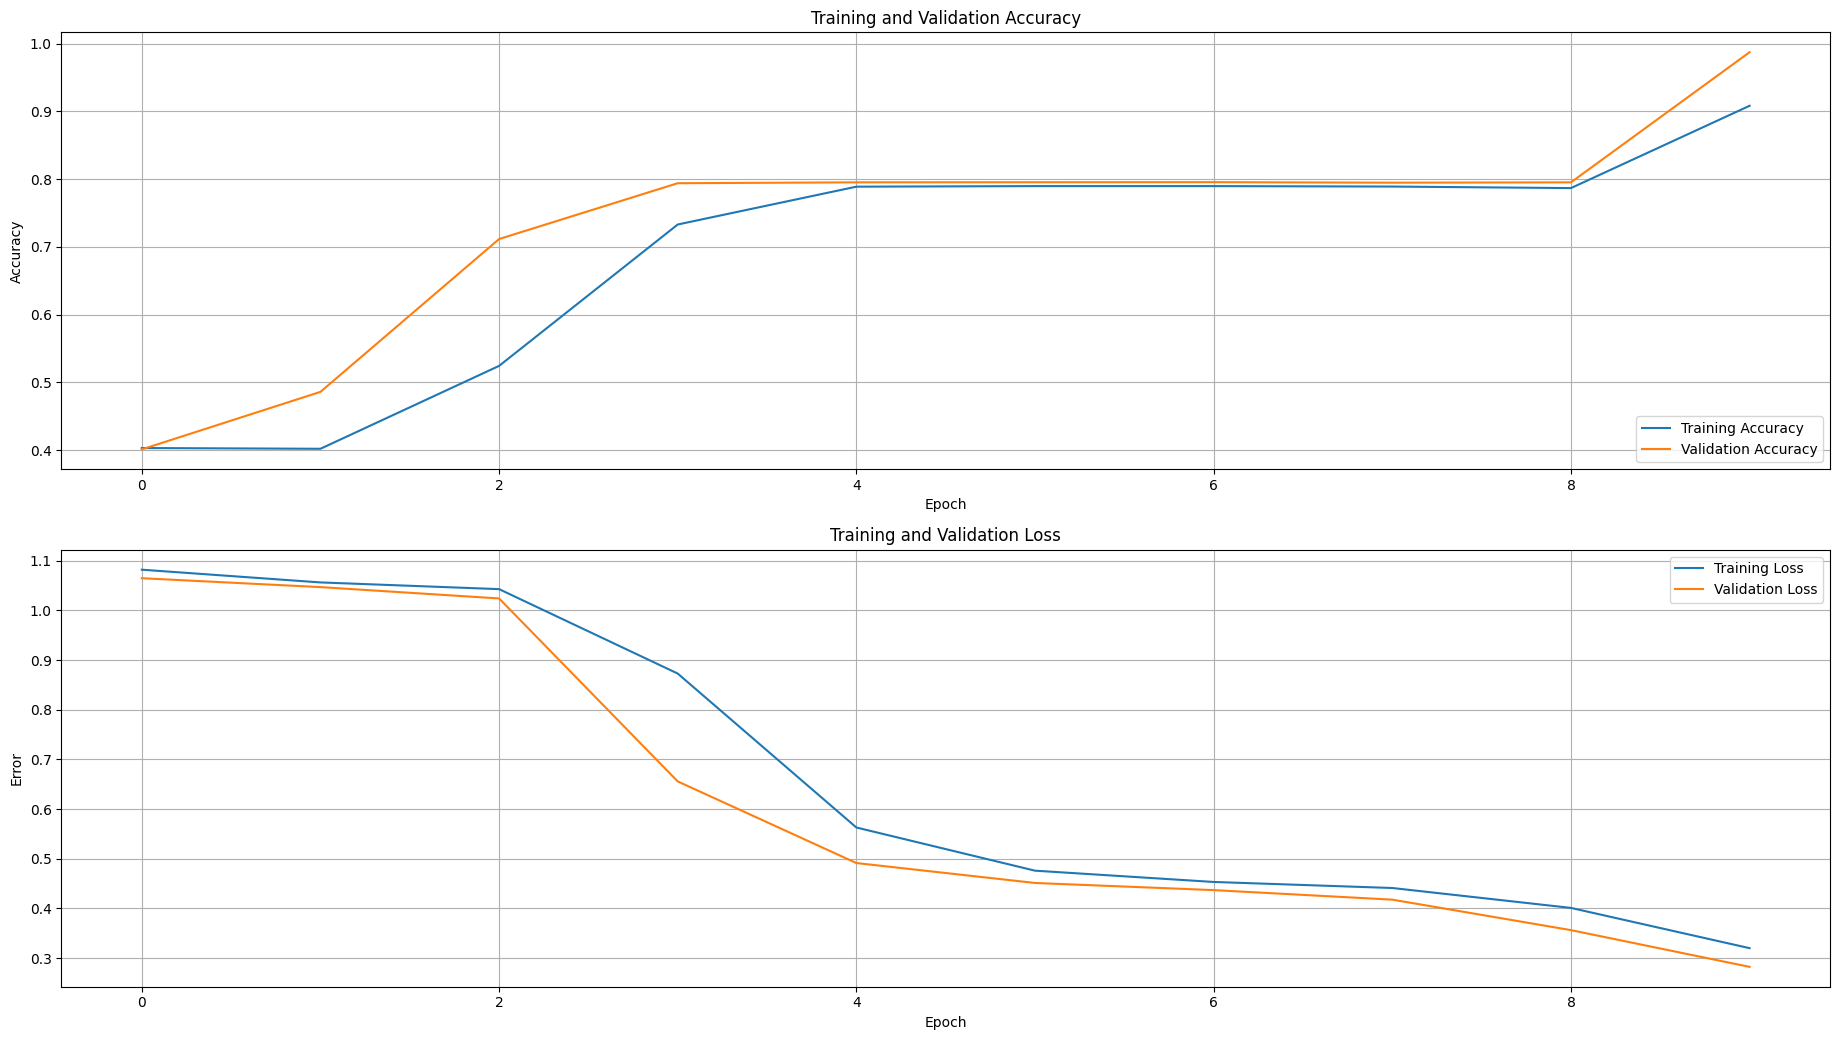

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3511 - loss: 1.9027 - sparse_categorical_accuracy: 0.3511
loss on test data with the first candidate model: 1.9027
accuracy on test data with the first candidate model: 0.3511


,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)
alt_enhanced_baseline_model,TextVectorization,0.0693,0.9929,2.2458,0.6910,64,64,32,rmsprop (default)
candidate_1_model,Tokenizer,0.2822,0.9873,1.9027,0.3511,8,4,8,0.0001


In [36]:
# build the model
candidate_1_model = tuner.hypermodel.build(candidate_1_hps)

# compile the model
candidate_1_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=candidate_1_hps.get('learning_rate')),  # uses 0.0001
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

# define parameters
batch_size = 64
epochs = 10

# train the model
history = candidate_1_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

# plot
plot_loss_and_acc(history, epochs)

# evaluate on test data using the first candidate model # uses tokenization to encode
results = candidate_1_model.evaluate(X_test, y_test)
print(f"loss on test data with the first candidate model: {results[0]:.4f}")
print(f"accuracy on test data with the first candidate model: {results[1]:.4f}")

# add the first candidate model to the comparison dataframe
add_to_df_models('candidate_1_model', 'Tokenizer', test_eval=True, embedding_dim=8, conv_filters=4, lstm_units=8, learning_rate=0.0001)
df_model_results

### Second Candidate Model

The second candidate model is built using the same hyperparameters as the first candidate model, except for the learning rate:
```output
{'embedding_dim': 8, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': rmsprop}
```

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6530 - loss: 0.7147 - sparse_categorical_accuracy: 0.6530 - val_accuracy: 0.7947 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.7947
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9266 - loss: 0.2200 - sparse_categorical_accuracy: 0.9266 - val_accuracy: 0.9871 - val_loss: 0.0672 - val_sparse_categorical_accuracy: 0.9871
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9878 - loss: 0.0436 - sparse_categorical_accuracy: 0.9878 - val_accuracy: 0.9888 - val_loss: 0.0368 - val_sparse_categorical_accuracy: 0.9888
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9910 - loss: 0.0320 - sparse_categorical_accuracy: 0.9910 - val_accuracy: 0.9896 - val_loss: 0.0323 - val_sparse_categorical_accuracy: 0.9896
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9918 - loss: 0.0252 - sparse_categorical_accuracy: 0.9918 - val_accuracy: 0.9892 - val_loss: 0.03

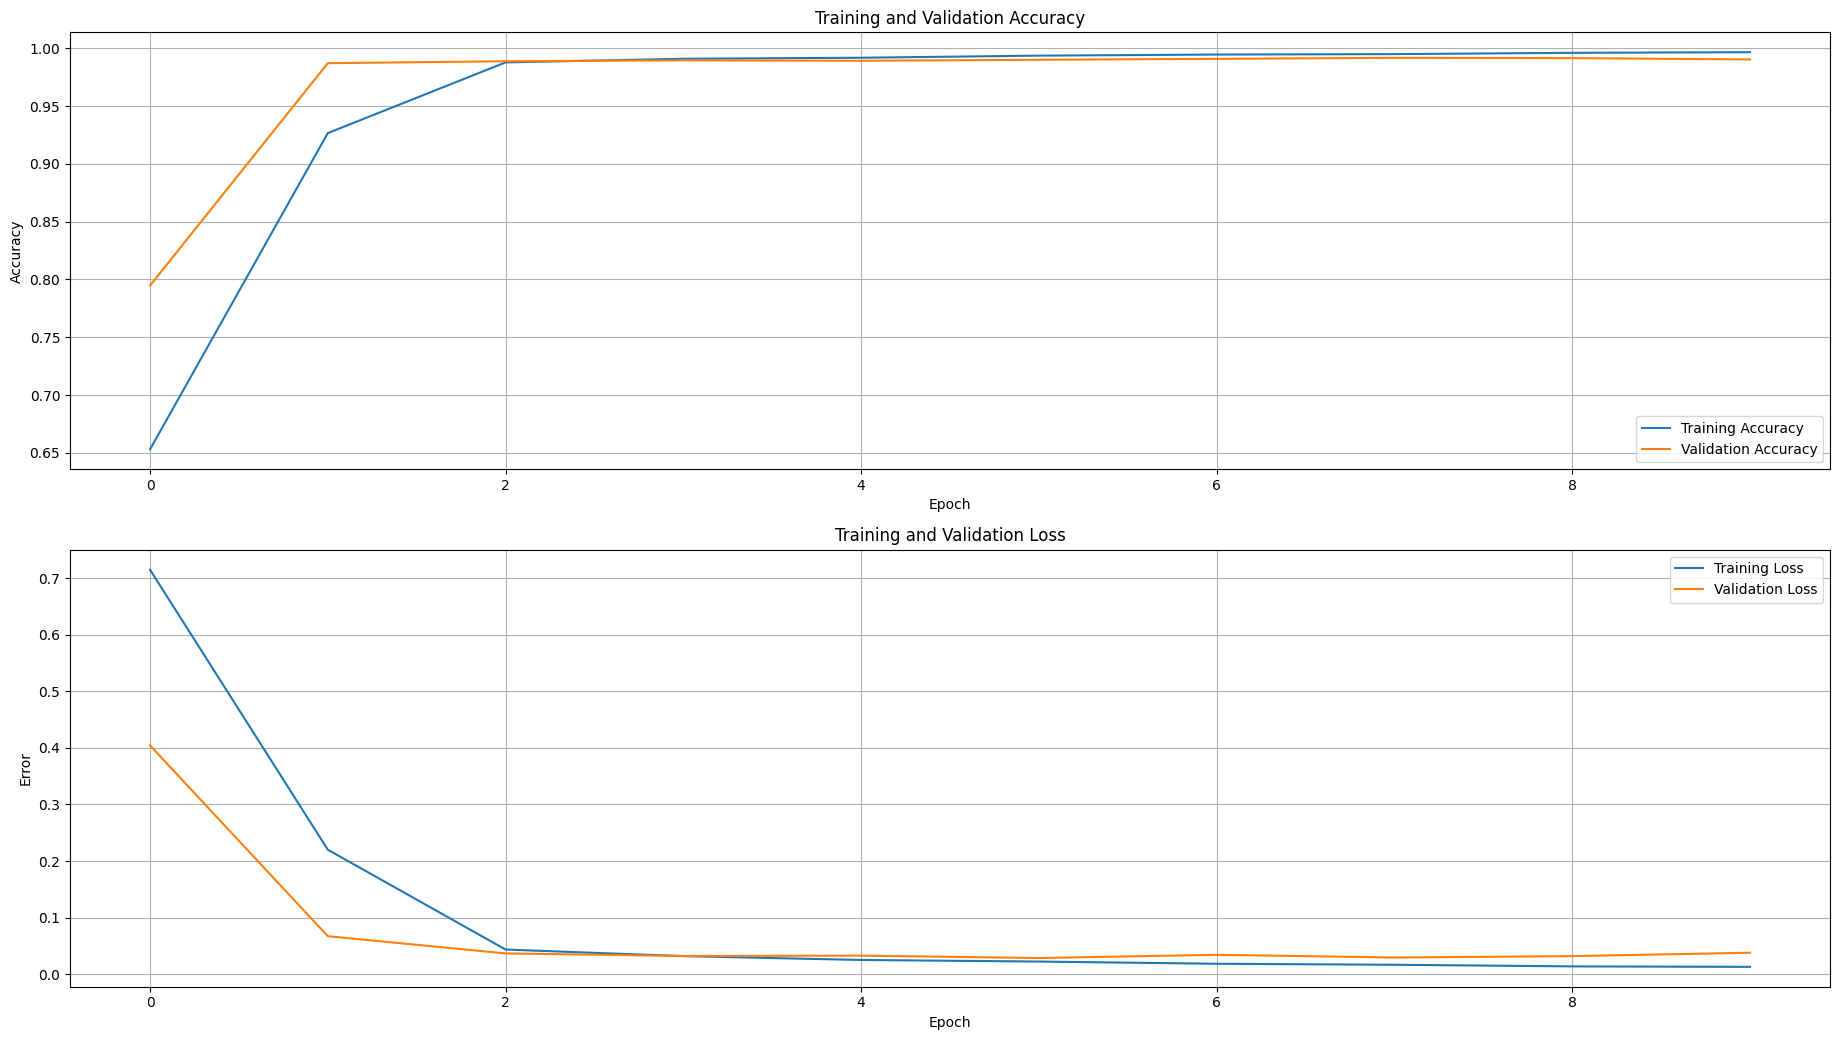

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4207 - loss: 3.2053 - sparse_categorical_accuracy: 0.4207
loss on test data with the second candidate model: 3.2053
accuracy on test data with the second candidate model: 0.4207


,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)
alt_enhanced_baseline_model,TextVectorization,0.0693,0.9929,2.2458,0.6910,64,64,32,rmsprop (default)
candidate_1_model,Tokenizer,0.2822,0.9873,1.9027,0.3511,8,4,8,0.0001
candidate_2_model,Tokenizer,0.0380,0.9903,3.2053,0.4207,8,4,8,rmsprop (default)


In [37]:
# build the model
candidate_2_model = tuner.hypermodel.build(candidate_1_hps)

# compile the model
candidate_2_model.compile(
    optimizer="rmsprop",  # uses rmsprop
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

# define parameters
batch_size = 64
epochs = 10

# train the model
history = candidate_2_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

# plot
plot_loss_and_acc(history, epochs)

# evaluate on test data using the second candidate model # uses tokenization to encode
results = candidate_2_model.evaluate(X_test, y_test)
print(f"loss on test data with the second candidate model: {results[0]:.4f}")
print(f"accuracy on test data with the second candidate model: {results[1]:.4f}")

# add the second candidate model to the comparison dataframe
add_to_df_models('candidate_2_model', 'Tokenizer', test_eval=True, embedding_dim=8, conv_filters=4, lstm_units=8, learning_rate='rmsprop (default)')
df_model_results

### Third Candidate Model
The third candidate model is built using the hyperparameters below:
```output
{'embedding_dim': 4, 'conv_filters': 4, 'lstm_units': 8, 'learning_rate': 0.0001}
```

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4058 - loss: 1.0705 - sparse_categorical_accuracy: 0.4058 - val_accuracy: 0.4013 - val_loss: 1.0501 - val_sparse_categorical_accuracy: 0.4013
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4190 - loss: 1.0516 - sparse_categorical_accuracy: 0.4190 - val_accuracy: 0.4013 - val_loss: 1.0474 - val_sparse_categorical_accuracy: 0.4013
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4676 - loss: 1.0496 - sparse_categorical_accuracy: 0.4676 - val_accuracy: 0.4013 - val_loss: 1.0451 - val_sparse_categorical_accuracy: 0.4013
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5792 - loss: 1.0461 - sparse_categorical_accuracy: 0.5792 - val_accuracy: 0.6363 - val_loss: 1.0399 - val_sparse_categorical_accuracy: 0.6363
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6273 - loss: 1.0339 - sparse_categorical_accuracy: 0.6273 - val_accuracy: 0.4874 - val_loss: 1.00

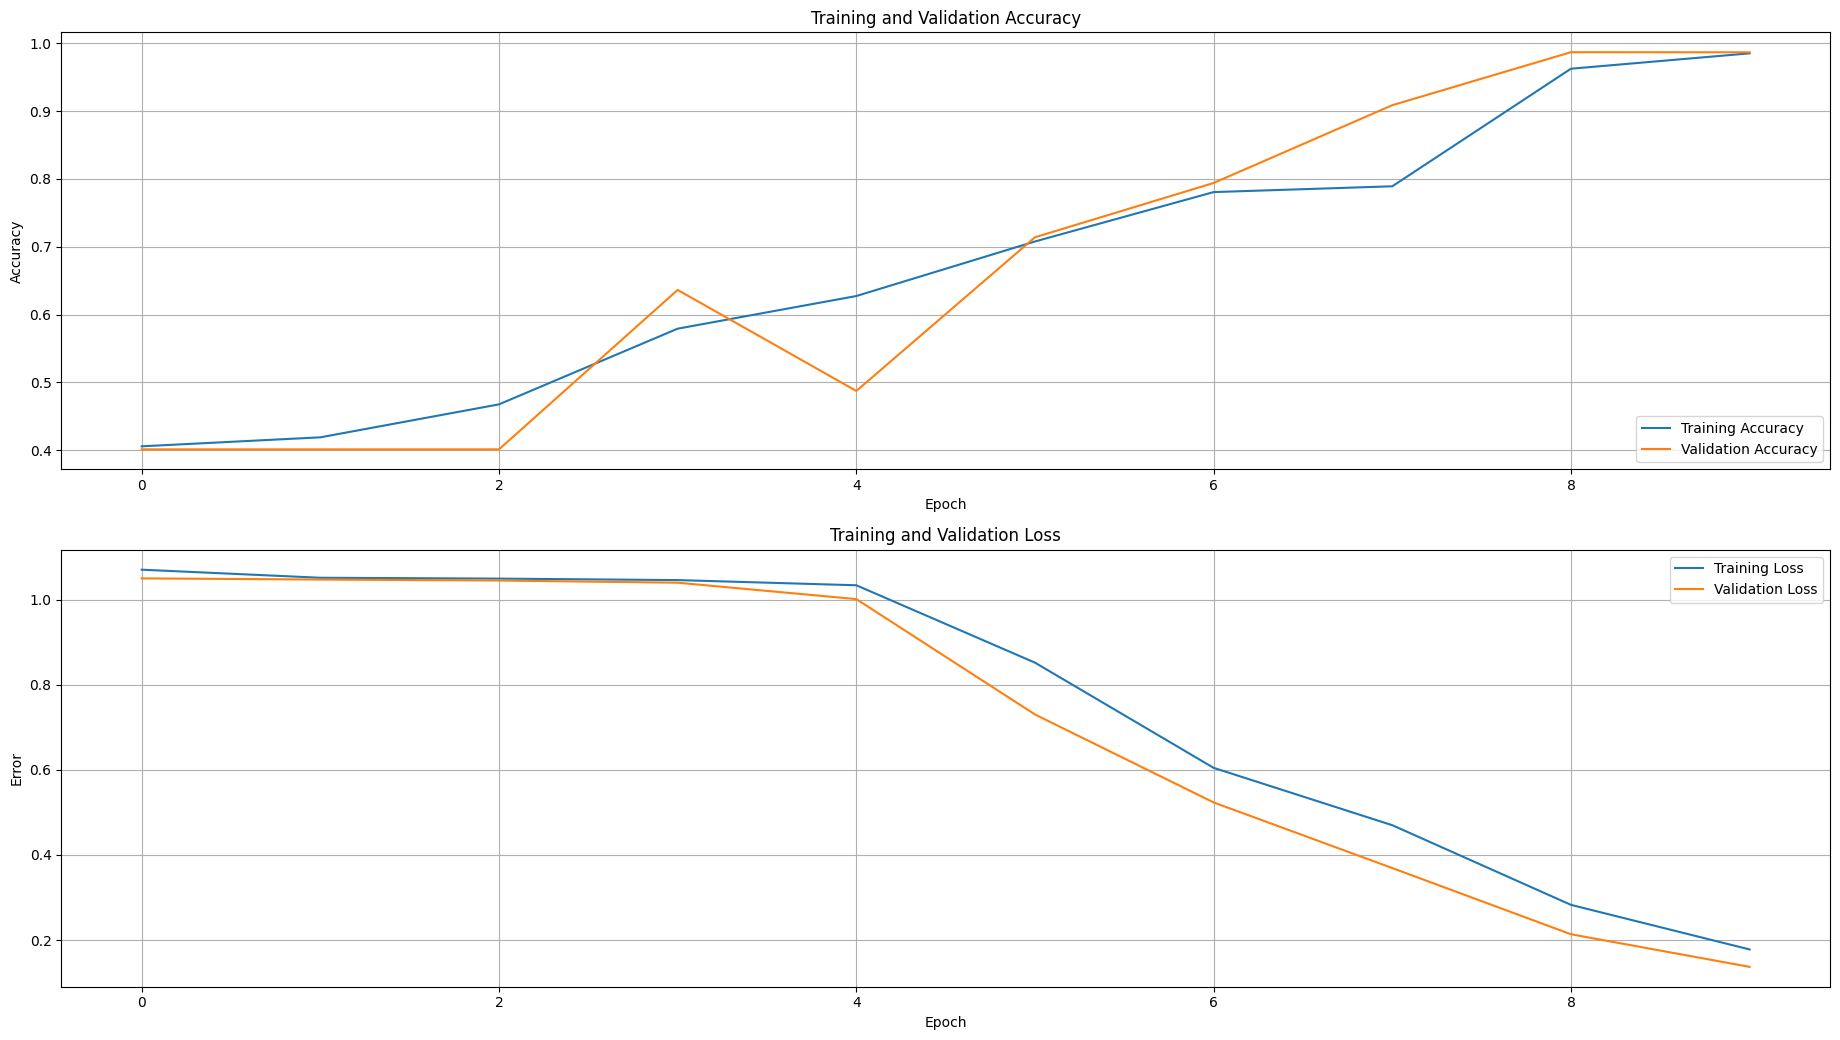

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3328 - loss: 1.7174 - sparse_categorical_accuracy: 0.3328
loss on test data with the third candidate model: 1.7174
accuracy on test data with the third candidate model: 0.3328


,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)
alt_enhanced_baseline_model,TextVectorization,0.0693,0.9929,2.2458,0.6910,64,64,32,rmsprop (default)
candidate_1_model,Tokenizer,0.2822,0.9873,1.9027,0.3511,8,4,8,0.0001
candidate_2_model,Tokenizer,0.0380,0.9903,3.2053,0.4207,8,4,8,rmsprop (default)
candidate_3_model,Tokenizer,0.1370,0.9866,1.7174,0.3328,4,4,8,0.0001


In [38]:
# build the model
candidate_3_model = tuner.hypermodel.build(candidate_3_hps)

# compile the model
candidate_3_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=candidate_3_hps.get('learning_rate')),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

# define parameters
batch_size = 64
epochs = 10

# train the model
history = candidate_3_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

# plot
plot_loss_and_acc(history, epochs)

# evaluate on test data using the third candidate model # uses tokenization to encode
results = candidate_3_model.evaluate(X_test, y_test)
print(f"loss on test data with the third candidate model: {results[0]:.4f}")
print(f"accuracy on test data with the third candidate model: {results[1]:.4f}")

# add the third candidate model to the comparison dataframe
add_to_df_models('candidate_3_model', 'Tokenizer', test_eval=True, embedding_dim=4, conv_filters=4, lstm_units=8, learning_rate=0.0001)
df_model_results

## Recurrent Neural Network: Model Comparison

A comparison of the models created so far is conducted to select the one that performs best on the test data, after which a regularization step can be added if needed.

In [39]:
df_model_results

,encoding,val_loss,val_accuracy,test_loss,test_accuracy,embedding_dim,conv_filters,lstm_units,learning_rate
baseline_model,Tokenizer,1.0501,0.4057,NaN,NaN,64,None,32,rmsprop (default)
enhanced_baseline_model,Tokenizer,0.0582,0.9925,1.6447,0.7804,64,64,32,rmsprop (default)
alt_enhanced_baseline_model,TextVectorization,0.0693,0.9929,2.2458,0.6910,64,64,32,rmsprop (default)
candidate_1_model,Tokenizer,0.2822,0.9873,1.9027,0.3511,8,4,8,0.0001
candidate_2_model,Tokenizer,0.0380,0.9903,3.2053,0.4207,8,4,8,rmsprop (default)
candidate_3_model,Tokenizer,0.1370,0.9866,1.7174,0.3328,4,4,8,0.0001


According to the data, aside from the baseline model, all other variants achieve high accuracy during training-validation. This indicates that the LSTM layer alone is not sufficient to learn the training dataset well. Therefore, a new architecture is created by adding convolutional and pooling layers, which improves performance by a large margin, regardless of how the input is encoded using a `Tokenizer` or `TextVectorizer`.

Models built on top of the new architecture learn the context pften within two epochs, reaching around 99% accuracy when using large hyperparameter values. This indicates overfitting.

When models use smaller hyperparameter values, as in the case of the three candidate models, the third candidate model stands out because the gap between accuracies on the validation and testing datasets is small, indicating that the model generalizes well. It is possible that the relatively low accuracy on the testing dataset is related to the dataset itself.

In conclusion, the **third candidate model performs similarly to the best-performing models while requiring cheaper computation. However, it is still overfitted**, so regularization will be added to the architecture and the final performance will be re-evaluated.

## Recurrent Neural Network: Regularization

`Dropout` is a regularization technique used to prevent overfitting in neural networks. During training, it randomly "drops" (sets to zero) a percentage of the neurons in the network to generalize better to new data.

***

`L2 regularization` (weight decay) is a technique that penalizes large weights in the model by adding a penalty to the loss function. It helps reduce overfitting by encouraging the model to use smaller weights, which often leads to better generalization.

Here, it is applied to the weights of the `Dense` layer, discouraging the network from having overly large weights. A smaller value means less regularization.

***

`EarlyStopping` is a technique used to stop the training process early if the model's performance on the validation set stops improving. It helps prevent overfitting by ensuring that the model doesn't train for too many epochs and start memorizing the training data instead of generalizing.

Epoch 1/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5451 - loss: 0.9108 - sparse_categorical_accuracy: 0.5451 - val_accuracy: 0.7938 - val_loss: 0.4698 - val_sparse_categorical_accuracy: 0.7938
Epoch 2/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7618 - loss: 0.5283 - sparse_categorical_accuracy: 0.7618 - val_accuracy: 0.7967 - val_loss: 0.4229 - val_sparse_categorical_accuracy: 0.7967
Epoch 3/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7809 - loss: 0.4568 - sparse_categorical_accuracy: 0.7809 - val_accuracy: 0.7974 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.7974
Epoch 4/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8778 - loss: 0.2790 - sparse_categorical_accuracy: 0.8778 - val_accuracy: 0.9864 - val_loss: 0.0995 - val_sparse_categorical_accuracy: 0.9864
Epoch 5/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9584 - loss: 0.1608 - sparse_categorical_accuracy: 0.9584 - val_accuracy: 0.9853 - val_loss:

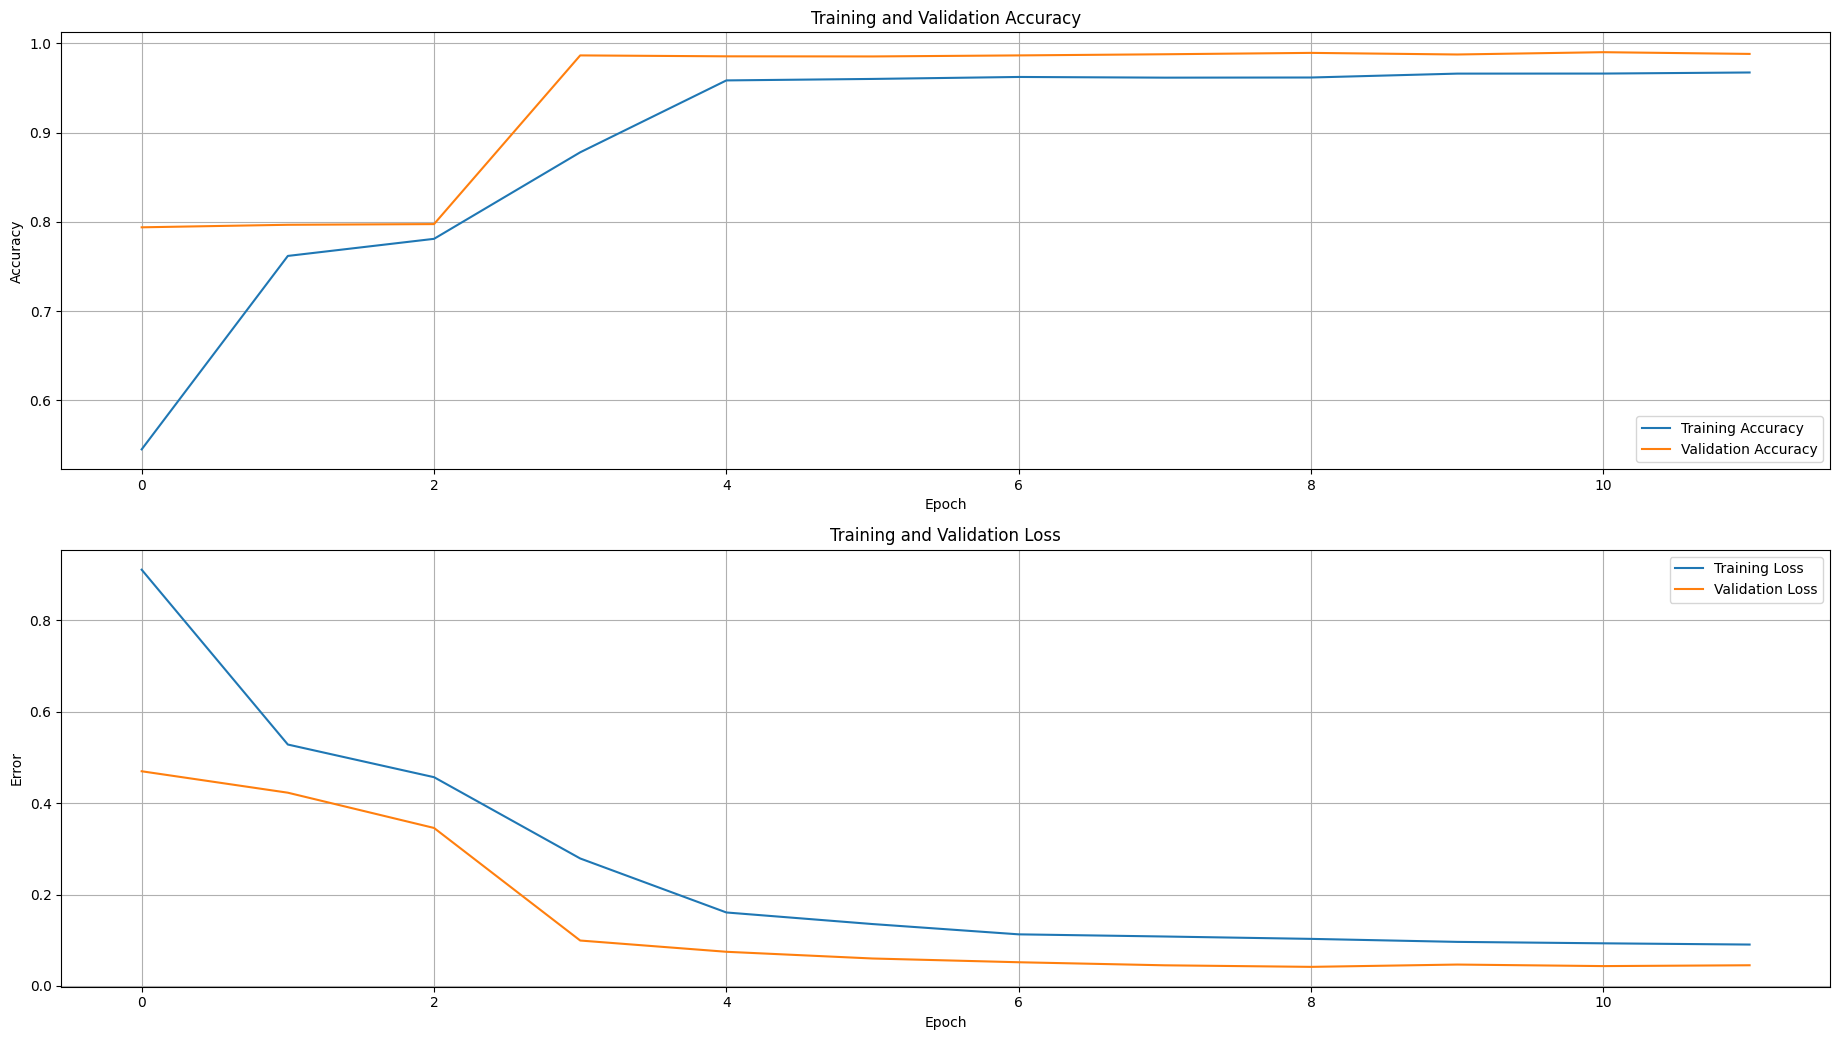

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7003 - loss: 1.6821 - sparse_categorical_accuracy: 0.7003
loss on test data with the best model: 1.6821
accuracy on test data with the best model: 0.7003


In [40]:
embedding_dim = 4
conv_filters = 4
lstm_units = 8
batch_size = 64
epochs = 30  # set higher since early stopping will prevent overfitting

# build the model
best_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(token_size, embedding_dim),
    tf.keras.layers.Conv1D(conv_filters, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(lstm_units, return_sequences=True, 
                         dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-4))
])

# compile the model
best_model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

# add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # stop if no improvement for 3 epochs
    restore_best_weights=True  # restore weights from best epoch
)

# train the model
history = best_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # add callback
)

# plot
plot_loss_and_acc(history, len(history.history['loss']))

# evaluate on test data
results = best_model.evaluate(X_test, y_test)
print(f"loss on test data with the best model: {results[0]:.4f}")
print(f"accuracy on test data with the best model: {results[1]:.4f}")

## Recurrent Neural Network: Confusion Matrix & Model Testing

After optimizing the model by fine-tuning the hyperparameters and adding regularization, the model is evaluated using the testing dataset.

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy on test data with the best model: 0.700301
F1-macro on test data with the best model: 0.446264
class names: ['Negative', 'Positive', 'Neutral']


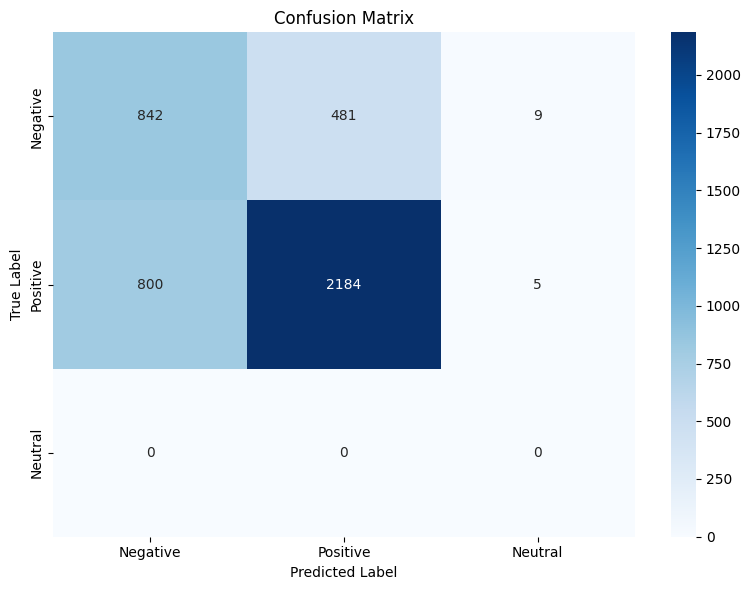

In [41]:
# make predictions using best model
y_pred_probs = best_model.predict(X_test)

# convert probabilities to class labels
y_pred_test = np.argmax(y_pred_probs, axis=1)

# evaluate scores on testing dataset
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"Accuracy on test data with the best model: {test_accuracy:.6f}")
print(f"F1-macro on test data with the best model: {test_f1_macro:.6f}")

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

## actual labels
class_names = []

## get unique classes (integers)
classes = sorted(df_train['sentiment'].unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Negative")
    elif c == 1:
        class_names.append("Positive")
    elif c == 2:
        class_names.append("Neutral")

print(f"class names: {class_names}")

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

When the model makes a prediction, it can identify positive instances better than negative ones. For the neutral class, there are very few neutral examples in the training dataset and no neutral examples in the testing dataset.

## Recurrent Neural Network: Model Testing with Any Reviews

In [42]:
review_to_predict = str(input("Enter a review: "))

def predict(review_to_predict):
    # preprocess: tokenize and pad
    review_sequence = tokenizer.texts_to_sequences([review_to_predict])
    review_padded = pad_sequences(review_sequence, maxlen=MAX_LEN, padding='post')

    # predict
    prediction_probs = best_model.predict(review_padded, verbose=0)
    prediction_class = np.argmax(prediction_probs[0])

    print(f"\nPrediction: {class_names[prediction_class]}")
    print(f"\nProbabilities:{class_names[0]}: {prediction_probs[0][0]:.4f}, "
          f"{class_names[1]}: {prediction_probs[0][1]:.4f}, "
          f"{class_names[2]}: {prediction_probs[0][2]:.4f}")

predict(review_to_predict)

Enter a review: The food served here is delicious.

Prediction: Positive

Probabilities:Negative: 0.3981, Positive: 0.4559, Neutral: 0.1460


## Recurrent Neural Network: Saving Model

For Keras models (especially those with `TextVectorization` and `LSTM` layers), the native `.keras` format should always be used to ensure all the complex weights and the internal vocabulary of the vectorization layer are preserved correctly.

In [43]:
best_model.save('../models/sentiment_analysis_rnn_tokenizer_model.keras')

This notebook is done by `La Wun Nannda`.